# 利用Keras對完美世界玩家做用戶活躍程度衰退預警

## import 套件

In [1]:
from keras.layers import Dense
from keras.models import Sequential
#from keras.optimizers import Adam
#import h5py

C:\Users\user\Anaconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#忽略掉瑣碎的警告訊息
import warnings
warnings.filterwarnings("ignore")

#######################################################################################
import matplotlib
import matplotlib.pyplot as plt
#matplotlib內建不支援中文，解決辦法：每次預先指定字體
matplotlib.rcParams.update({'font.size': 36})
matplotlib.use('qt4agg')
myfont = matplotlib.font_manager.FontProperties(fname='C:\\Windows\\Fonts\\msjh.ttc')
#指定字體
matplotlib.rcParams['axes.unicode_minus']=False

from matplotlib.ticker import FormatStrFormatter
majorFormatter = FormatStrFormatter('%0.f') #設定圖表浮點數的格式
%matplotlib inline 
#繪圖完就直接顯示該圖，省略每次繪圖完都要輸入plt.show指令的動作
#######################################################################################
import seaborn as sns



import pandas as pd
pd.set_option('display.max_columns', 100)  #設定可顯示欄位的上限
pd.options.display.float_format = '{:,.6f}'.format  #設定浮點數的格式

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## 資料預處理

In [3]:
data = pd.read_excel('GF_RFMmodelExample_20180521_W2.xlsx', encoding='utf8')
data.head(1)

,遊戲名稱,遊戲帳號,時間Key,RFM數字類型,RFM中文類型,價值指數,第一次儲值日期,最後一次儲值日期,平均儲值日期間隔,平均儲值日期區間,儲值次數,平均儲值金額,平均儲值金額區間,累積儲值金額,累積儲值金額區間,角色等級,最近上線時間,角色職業,修真,轉生級別,境界,魔書經驗,星運,魂力,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,轉生_未填坑,一轉等級
0,完美世界,31800459,2016-12-31,111,-_新戶,0.033000,2016-04-24,2016-04-24,251.000000,超過3個月,1,150,1K,150,1K,nan,NaT,NaN,NaN,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [4]:
data.shape[1]

32

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171374 entries, 0 to 171373
Data columns (total 32 columns):
遊戲名稱        171374 non-null object
遊戲帳號        171374 non-null object
時間Key       171374 non-null datetime64[ns]
RFM數字類型     171374 non-null int64
RFM中文類型     171374 non-null object
價值指數        171374 non-null float64
第一次儲值日期     171374 non-null datetime64[ns]
最後一次儲值日期    171374 non-null datetime64[ns]
平均儲值日期間隔    171374 non-null float64
平均儲值日期區間    171374 non-null object
儲值次數        171374 non-null int64
平均儲值金額      171374 non-null int64
平均儲值金額區間    171374 non-null object
累積儲值金額      171374 non-null int64
累積儲值金額區間    171374 non-null object
角色等級        92335 non-null float64
最近上線時間      88481 non-null datetime64[ns]
角色職業        96800 non-null object
修真          96800 non-null object
轉生級別        96755 non-null float64
境界          96755 non-null object
魔書經驗        96800 non-null float64
星運          96800 non-null float64
魂力          96800 non-null float64
傷害力指數       96800 non-n

In [6]:
data.describe()

,RFM數字類型,價值指數,平均儲值日期間隔,儲值次數,平均儲值金額,累積儲值金額,角色等級,轉生級別,魔書經驗,星運,魂力,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,轉生_未填坑,一轉等級
count,"171,374.000000","171,374.000000","171,374.000000","171,374.000000","171,374.000000","171,374.000000","92,335.000000","96,755.000000","96,800.000000","96,800.000000","96,800.000000","96,800.000000","96,800.000000","96,800.000000","96,755.000000","96,755.000000","96,755.000000","96,755.000000","96,755.000000"
mean,271.538326,0.467559,161.084636,71.489637,706.626192,"67,962.497870","1,755.857865",1.677588,"169,803,449.371219",2.362138,"19,506.068037","82,515.090486","221,405.440434","217,376.756415",10.314206,15.227575,5.636763,0.322412,87.928272
std,168.391518,0.764874,246.169271,155.924773,858.820110,"244,723.144103",733.692343,0.712381,"353,472,499.722779",1.597586,"8,497.971526","117,382.975649","328,290.840927","163,856.793656",12.522392,19.273492,1.597145,0.712381,36.178575
min,111.000000,0.033000,0.030000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,112.000000,0.066000,21.430000,3.000000,300.000000,"1,150.000000","2,101.000000",2.000000,0.000000,1.000000,"15,557.000000","19,630.000000","26,080.000000","143,387.000000",0.000000,0.000000,4.000000,0.000000,100.000000
50%,213.000000,0.165000,66.380000,17.000000,500.000000,"8,000.000000","2,103.000000",2.000000,"1,290,391.000000",3.000000,"17,068.000000","47,139.000000","104,791.000000","205,350.000000",9.000000,4.000000,5.000000,0.000000,102.000000
75%,422.000000,0.496000,201.500000,74.000000,844.000000,"44,000.000000","2,105.000000",2.000000,"137,722,366.000000",4.000000,"20,507.000000","94,474.000000","276,600.000000","286,628.000000",19.000000,30.000000,7.000000,0.000000,105.000000
max,555.000000,4.135000,"3,775.000000","6,000.000000","30,000.000000","14,728,950.000000","2,105.000000",2.000000,"1,800,000,000.000000",8.000000,"56,835.000000","1,415,308.000000","4,015,841.000000","1,348,603.000000",41.000000,50.000000,8.000000,2.000000,105.000000


In [7]:
#data['角色職業'].value_counts()
#data.groupby('修真')['修真_未填坑'].describe()

In [8]:
#角色職業的遺失值由最多人選擇的職業來填補
data['角色職業'] = data['角色職業'].fillna(data['角色職業'].value_counts().index[0])

#修真未填坑等於0，代表修真部分玩家已經全玩過，因此填代表修真最高等級的41至聖
data.loc[(data.修真.isnull()) & (data['修真_未填坑']==0), '修真']='41至聖'

#根據已知修真類別來填補修真_未填坑的遺失值
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='00大乘以下'), '修真_未填坑']=38
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='20上仙'), '修真_未填坑']=21
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='22天仙'), '修真_未填坑']=20
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='21真仙'), '修真_未填坑']=19
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='30狂魔'), '修真_未填坑']=11
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='31魔聖'), '修真_未填坑']=10
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='32魔尊'), '修真_未填坑']=9
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='40混元'), '修真_未填坑']=1
data.loc[(data.修真_未填坑.isnull()) & (data['修真']=='41至聖'), '修真_未填坑']=0


#根據已知星運類別來填補星運_未填坑的遺失值
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==0), '星運_未填坑']=8
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==1), '星運_未填坑']=7
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==2), '星運_未填坑']=6
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==3), '星運_未填坑']=5
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==4), '星運_未填坑']=4
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==5), '星運_未填坑']=3
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==6), '星運_未填坑']=2
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==7), '星運_未填坑']=1
data.loc[(data.星運_未填坑.isnull()) & (data['星運']==8), '星運_未填坑']=0


#根據已知境界未填坑來填補境界的遺失值
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==0), '境界']='均天十重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==1), '境界']='均天九重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==2), '境界']='均天八重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==3), '境界']='均天七重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==4), '境界']='均天六重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==5), '境界']='均天五重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==6), '境界']='均天四重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==7), '境界']='均天三重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==8), '境界']='均天二重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==9), '境界']='均天一重'

data.loc[(data.境界.isnull()) & (data['境界_未填坑']==10), '境界']='動天十重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==11), '境界']='動天九重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==12), '境界']='動天八重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==13), '境界']='動天七重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==14), '境界']='動天六重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==15), '境界']='動天五重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==16), '境界']='動天四重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==17), '境界']='動天三重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==18), '境界']='動天二重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==19), '境界']='動天一重'

data.loc[(data.境界.isnull()) & (data['境界_未填坑']==20), '境界']='周天十重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==21), '境界']='周天九重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==22), '境界']='周天八重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==23), '境界']='周天七重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==24), '境界']='周天六重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==25), '境界']='周天五重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==26), '境界']='周天四重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==27), '境界']='周天三重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==28), '境界']='周天二重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==29), '境界']='周天一重'

data.loc[(data.境界.isnull()) & (data['境界_未填坑']==30), '境界']='幻天十重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==31), '境界']='幻天九重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==32), '境界']='幻天八重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==33), '境界']='幻天七重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==34), '境界']='幻天六重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==35), '境界']='幻天五重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==36), '境界']='幻天四重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==37), '境界']='幻天三重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==38), '境界']='幻天二重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==39), '境界']='幻天一重'

data.loc[(data.境界.isnull()) & (data['境界_未填坑']==40), '境界']='玄天十重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==41), '境界']='玄天九重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==42), '境界']='玄天八重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==43), '境界']='玄天七重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==44), '境界']='玄天六重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==45), '境界']='玄天五重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==46), '境界']='玄天四重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==47), '境界']='玄天三重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==48), '境界']='玄天二重'
data.loc[(data.境界.isnull()) & (data['境界_未填坑']==49), '境界']='玄天一重'


In [9]:
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44093 entries, 15 to 171373
Data columns (total 32 columns):
遊戲名稱        44093 non-null object
遊戲帳號        44093 non-null object
時間Key       44093 non-null datetime64[ns]
RFM數字類型     44093 non-null int64
RFM中文類型     44093 non-null object
價值指數        44093 non-null float64
第一次儲值日期     44093 non-null datetime64[ns]
最後一次儲值日期    44093 non-null datetime64[ns]
平均儲值日期間隔    44093 non-null float64
平均儲值日期區間    44093 non-null object
儲值次數        44093 non-null int64
平均儲值金額      44093 non-null int64
平均儲值金額區間    44093 non-null object
累積儲值金額      44093 non-null int64
累積儲值金額區間    44093 non-null object
角色等級        44093 non-null float64
最近上線時間      44093 non-null datetime64[ns]
角色職業        44093 non-null object
修真          44093 non-null object
轉生級別        44093 non-null float64
境界          44093 non-null object
魔書經驗        44093 non-null float64
星運          44093 non-null float64
魂力          44093 non-null float64
傷害力指數       44093 non-null float64
生存指

## 建立樣本標籤
### 將屬於退坑、停滯、停儲狀態的玩家定義為流失客戶。

In [10]:
data['RFM判斷是否為價值客戶'] = 1

data.loc[data['RFM中文類型']=='N_停儲' ,'RFM判斷是否為價值客戶']=0
data.loc[data['RFM中文類型']=='N_停滯' ,'RFM判斷是否為價值客戶']=0
data.loc[data['RFM中文類型']=='N_退坑' ,'RFM判斷是否為價值客戶']=0

data['RFM判斷是否為價值客戶'].value_counts()

0    28308
1    15785
Name: RFM判斷是否為價值客戶, dtype: int64

In [11]:
df = data[['平均儲值日期間隔','儲值次數', '平均儲值金額','角色等級','累積儲值金額',
           '傷害力指數', '生存指數', '聲望', 'RFM判斷是否為價值客戶', '星運', '魂力',
           '魔書經驗', '傷害力指數', '生存指數', '聲望', '修真_未填坑',
           '境界_未填坑', '星運_未填坑', '一轉等級','角色職業', '境界', '修真']]

In [12]:
df.sample()

,平均儲值日期間隔,儲值次數,平均儲值金額,角色等級,累積儲值金額,傷害力指數,生存指數,聲望,RFM判斷是否為價值客戶,星運,魂力,魔書經驗,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,一轉等級,角色職業,境界,修真
8209,247.000000,1,50,95.000000,50,"5,895.000000","4,072.000000",165.000000,1,0.000000,"14,266.000000",0.000000,"5,895.000000","4,072.000000",165.000000,38.000000,50.000000,8.000000,0.000000,妖精,0,00大乘以下


In [13]:
df = pd.get_dummies(df, columns=['角色職業'])
df = pd.get_dummies(df, columns=['修真'])
df = pd.get_dummies(df, columns=['境界'])

## 目標變數用one-hot-encoding來表示

In [14]:
y = pd.get_dummies(df['RFM判斷是否為價值客戶'])
y.head()

,0,1
15,1,0
16,1,0
19,1,0
20,0,1
21,0,1


## 特徵標準化
### 訓練資料必須為數值類型，int or float

In [15]:
df = df.drop(['RFM判斷是否為價值客戶'], axis=1)
df = df.values

scaler = MinMaxScaler()
df = scaler.fit_transform(df)

## 切分訓練、驗證樣本

In [16]:
#使用sklearn中 train_test_split函數來切分數據
train_x, val_x, train_y, val_y = train_test_split(df, y, 
                                                  random_state = 0,
                                                  test_size=0.1)

In [17]:
print(train_x.shape, val_x.shape)

(39683, 90) (4410, 90)


In [18]:
train_x[0]

array([1.43964563e-02, 1.08401084e-02, 1.52450942e-02, 9.97623574e-01,
       2.26464336e-03, 3.53279993e-06, 1.44428029e-05, 0.00000000e+00,
       0.00000000e+00, 8.97334389e-04, 0.00000000e+00, 3.53279993e-06,
       1.44428029e-05, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [19]:
train_y.sample()

,0,1
151182,1,0


## 建立模型

In [20]:
def model1():
    model = Sequential()
    model.add(Dense(units=256, input_dim=train_x.shape[1], activation='relu'))  
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=4, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))  
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model1 = model1()

## 訓練模型

In [21]:
history = model1.fit(train_x, train_y, epochs=80, validation_data=([val_x, val_y]),
                     batch_size=8, verbose=2)

Train on 39683 samples, validate on 4410 samples
Epoch 1/80
 - 8s - loss: 0.5731 - acc: 0.7043 - val_loss: 0.5524 - val_acc: 0.7152
Epoch 2/80
 - 7s - loss: 0.5429 - acc: 0.7278 - val_loss: 0.5398 - val_acc: 0.7265
Epoch 3/80
 - 7s - loss: 0.5278 - acc: 0.7375 - val_loss: 0.5393 - val_acc: 0.7259
Epoch 4/80
 - 7s - loss: 0.5141 - acc: 0.7462 - val_loss: 0.5286 - val_acc: 0.7322
Epoch 5/80
 - 7s - loss: 0.5013 - acc: 0.7518 - val_loss: 0.5129 - val_acc: 0.7397
Epoch 6/80
 - 8s - loss: 0.4911 - acc: 0.7558 - val_loss: 0.5135 - val_acc: 0.7435
Epoch 7/80
 - 8s - loss: 0.4806 - acc: 0.7626 - val_loss: 0.5153 - val_acc: 0.7297
Epoch 8/80
 - 8s - loss: 0.4753 - acc: 0.7631 - val_loss: 0.4956 - val_acc: 0.7515
Epoch 9/80
 - 7s - loss: 0.4687 - acc: 0.7661 - val_loss: 0.5020 - val_acc: 0.7524
Epoch 10/80
 - 7s - loss: 0.4618 - acc: 0.7703 - val_loss: 0.4921 - val_acc: 0.7531
Epoch 11/80
 - 7s - loss: 0.4532 - acc: 0.7757 - val_loss: 0.4913 - val_acc: 0.7639
Epoch 12/80
 - 7s - loss: 0.4490 - a

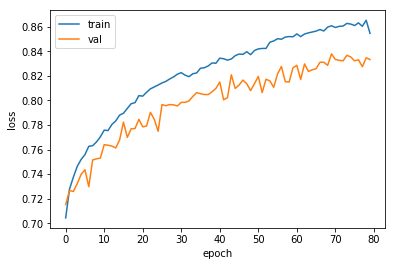

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='best')

## 模型輸出

In [23]:
model1.predict(train_x)

array([[0.92870367, 0.07129628],
       [0.9926732 , 0.00732674],
       [0.9648386 , 0.03516138],
       ...,
       [0.        , 1.        ],
       [0.4959987 , 0.50400126],
       [0.96364504, 0.03635497]], dtype=float32)

## model效能檢視

In [24]:
train_pred_label = model1.predict_classes(train_x)
accuracy=accuracy_score(train_y[1],train_pred_label)
print('模型在訓練樣本上的 accuracy:', accuracy)

模型在訓練樣本上的 accuracy: 0.8708262984149384


In [25]:
val_pred_label = model1.predict_classes(val_x)
accuracy=accuracy_score(val_y[1],val_pred_label)
print('模型在驗證樣本上的 accuracy:', accuracy)

模型在驗證樣本上的 accuracy: 0.8333333333333334


In [26]:
all_pred_label = model1.predict_classes(df)
accuracy=accuracy_score(y[1],all_pred_label)
print('模型在所有樣本上的 accuracy:', accuracy)

模型在所有樣本上的 accuracy: 0.8670764066858685


## 使用 confusion matrix 檢查模型的分類狀況

Text(0.5,15,'Predicted label')

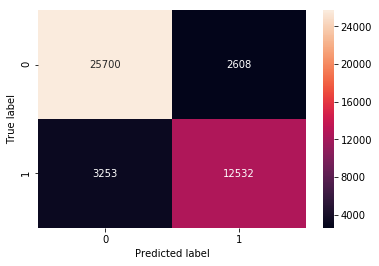

In [27]:
from sklearn.metrics import confusion_matrix
y_pred = all_pred_label
g = sns.heatmap(confusion_matrix(y[1],y_pred),annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')

## 客戶活躍程度衰退預警名單
### 從價值客戶中尋找衰退至退坑、停儲、停滯狀態的玩家，建立可能衰退玩家名單，做為制定行銷策略的參考資料。

In [28]:
all_pred_proba = model1.predict(df)

data['Deep Learning預測是否為價值客戶'] = all_pred_label
data['Deep Learning預測衰退機率'] = list(all_pred_proba[:,0])

value_data = data[data['RFM判斷是否為價值客戶'] == 1]

result = value_data

result = result.drop_duplicates('遊戲帳號', keep='last')
result = result.sort_values(['Deep Learning預測衰退機率'], ascending=False)
result = result[result['Deep Learning預測是否為價值客戶'] == 0]
result = result[result['RFM中文類型'] == 'P_價值']

result = result[['遊戲名稱', '遊戲帳號', '時間Key','RFM判斷是否為價值客戶', 'Deep Learning預測是否為價值客戶',
                 'Deep Learning預測衰退機率','RFM數字類型', 'RFM中文類型', '價值指數', '第一次儲值日期',
                 '最後一次儲值日期', '平均儲值日期間隔', '平均儲值日期區間', '儲值次數', '平均儲值金額', '平均儲值金額區間',
                 '累積儲值金額', '累積儲值金額區間', '角色等級', '最近上線時間', '角色職業', '修真', '轉生級別', '境界',
                 '魔書經驗', '星運', '魂力', '傷害力指數', '生存指數', '聲望', '修真_未填坑', '境界_未填坑', '星運_未填坑',
                 '轉生_未填坑', '一轉等級']]
result.head()

,遊戲名稱,遊戲帳號,時間Key,RFM判斷是否為價值客戶,Deep Learning預測是否為價值客戶,Deep Learning預測衰退機率,RFM數字類型,RFM中文類型,價值指數,第一次儲值日期,最後一次儲值日期,平均儲值日期間隔,平均儲值日期區間,儲值次數,平均儲值金額,平均儲值金額區間,累積儲值金額,累積儲值金額區間,角色等級,最近上線時間,角色職業,修真,轉生級別,境界,魔書經驗,星運,魂力,傷害力指數,生存指數,聲望,修真_未填坑,境界_未填坑,星運_未填坑,轉生_未填坑,一轉等級
149986,完美世界,tp6jo6cl62000,2017-12-31,1,0,1.000000,555,P_價值,4.135000,2007-09-10,2017-10-23,29.410000,1個月,128,1499,1K~2K,191830,100K~300K,"2,100.000000",2017-12-31,夜影,21真仙,2.000000,均天二重,"237,841,910.000000",3.000000,"15,457.000000","79,072.000000","90,926.000000","205,443.000000",20.000000,8.000000,5.000000,0.000000,103.000000
162770,完美世界,xyz88874,2018-05-21,1,0,1.000000,554,P_價值,3.308000,2007-05-14,2018-05-09,16.300000,3週,247,1243,1K~2K,306910,300K~500K,"2,103.000000",2018-05-19,妖獸,22天仙,2.000000,動天九重,"151,802,759.000000",2.000000,"23,754.000000","34,240.000000","411,000.000000","326,925.000000",19.000000,11.000000,6.000000,0.000000,105.000000
155733,完美世界,wai8821,2017-12-31,1,0,1.000000,521,P_價值,0.331000,2007-03-04,2017-10-21,91.980000,超過3個月,43,256,1K,11000,10K~30K,"1,101.000000",2017-12-31,武俠,21真仙,1.000000,玄天十重,0.000000,1.000000,"15,613.000000","12,992.000000","24,816.000000","45,052.000000",20.000000,40.000000,7.000000,1.000000,101.000000
49761,完美世界,fax444,2017-12-31,1,0,1.000000,454,P_價值,2.647000,2010-07-02,2017-10-05,16.400000,3週,167,1043,1K~2K,174250,100K~300K,"2,100.000000",2017-12-31,刺客,30狂魔,2.000000,幻天七重,0.000000,1.000000,"16,303.000000","17,085.000000","32,488.000000","203,980.000000",11.000000,33.000000,7.000000,0.000000,100.000000
155967,完美世界,wangjuikuo5883,2017-12-31,1,0,0.999992,412,P_價值,0.265000,2010-12-31,2017-10-10,319.630000,超過3個月,8,538,1K,4300,1K~5K,"2,103.000000",2017-12-29,武俠,40混元,2.000000,均天六重,0.000000,0.000000,"16,588.000000","35,971.000000","82,580.000000","820,156.000000",1.000000,4.000000,8.000000,0.000000,103.000000


In [29]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817 entries, 149986 to 32111
Data columns (total 35 columns):
遊戲名稱                      817 non-null object
遊戲帳號                      817 non-null object
時間Key                     817 non-null datetime64[ns]
RFM判斷是否為價值客戶              817 non-null int64
Deep Learning預測是否為價值客戶    817 non-null int64
Deep Learning預測衰退機率       817 non-null float64
RFM數字類型                   817 non-null int64
RFM中文類型                   817 non-null object
價值指數                      817 non-null float64
第一次儲值日期                   817 non-null datetime64[ns]
最後一次儲值日期                  817 non-null datetime64[ns]
平均儲值日期間隔                  817 non-null float64
平均儲值日期區間                  817 non-null object
儲值次數                      817 non-null int64
平均儲值金額                    817 non-null int64
平均儲值金額區間                  817 non-null object
累積儲值金額                    817 non-null int64
累積儲值金額區間                  817 non-null object
角色等級                      817 non-null 

## 練習

## 將模型輸出層的activation funtion改為 sigmoid

In [30]:
df2 = data[['平均儲值日期間隔','儲值次數', '平均儲值金額','角色等級','累積儲值金額',
           '傷害力指數', '生存指數', '聲望', 'RFM判斷是否為價值客戶', '星運', '魂力',
           '魔書經驗', '傷害力指數', '生存指數', '聲望', '修真_未填坑',
           '境界_未填坑', '星運_未填坑', '一轉等級','角色職業', '境界', '修真']]

In [31]:
df2 = pd.get_dummies(df2, columns=['角色職業'])
df2 = pd.get_dummies(df2, columns=['修真'])
df2 = pd.get_dummies(df2, columns=['境界'])

In [32]:
y = df2['RFM判斷是否為價值客戶']

In [33]:
df2 = df2.drop(['RFM判斷是否為價值客戶'], axis=1)
df2 = df2.values
df2 = scaler.fit_transform(df2)

In [34]:
train_x, val_x, train_y, val_y = train_test_split(df, y, 
                                                  random_state = 0,
                                                  test_size=0.1)

In [35]:
print(train_x.shape, val_x.shape)

(39683, 90) (4410, 90)


In [36]:
train_y.head()

134012    0
55580     0
14466     0
84046     0
132601    0
Name: RFM判斷是否為價值客戶, dtype: int64

In [37]:
def model2():
    model = Sequential()
    model.add(Dense(units=256, input_dim=train_x.shape[1], activation='relu'))  
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=4, activation='relu'))
    model.add(Dense(units=, activation=''))  
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model2 = model2()

SyntaxError: invalid syntax (<ipython-input-37-f1c67ab73090>, line 10)

In [ ]:
ss = model2.fit(train_x, train_y, epochs=150, validation_data=([val_x, val_y]),
                batch_size=8, verbose=2)

In [ ]:
train_pred_label = model2.predict_classes(train_x)
accuracy=accuracy_score(train_y,train_pred_label)
print('模型在訓練樣本上的 accuracy:', accuracy)

In [ ]:
val_pred_label = model2.predict_classes(val_x)
accuracy=accuracy_score(val_y,val_pred_label)
print('模型在驗證樣本上的 accuracy:', accuracy)

In [ ]:
all_pred_label = model2.predict_classes(df)
accuracy=accuracy_score(y,all_pred_label)
print('模型在所有樣本上的 accuracy:', accuracy)